In [10]:
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa
from IPython.display import Audio
%matplotlib inline

import audio_utils
import vamp


In [5]:
audio_file = 'wav/sucka-for-love.wav'

audio, sr = librosa.load(audio_file, mono=True)
data = vamp.collect(audio, sr, "mtg-melodia:melodia")
hop, melody = data['vector']

# for some reason the internal vamp architecture requires this
timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)

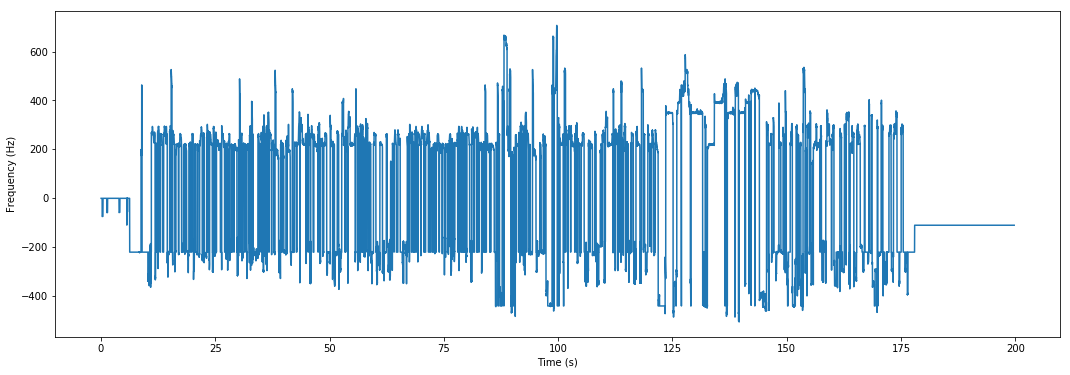

In [6]:
# Melodia returns unvoiced (=no melody) sections as negative values. So by default, we get:
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

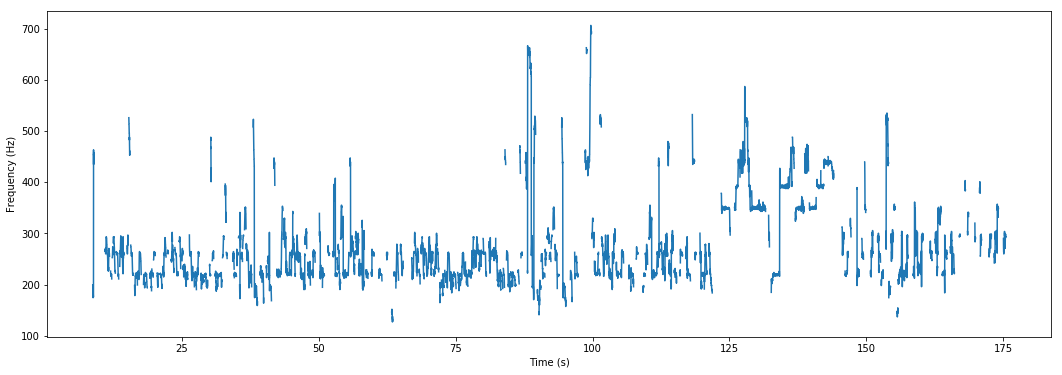

In [7]:
# A clearer option is to get rid of the negative values before plotting
melody_pos = melody[:]
melody_pos[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody_pos)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [12]:
# Audio(melody, rate=sr)
print(timestamps)

[2.32199546e-02 2.61224490e-02 2.90249433e-02 ... 1.99746757e+02
 1.99749660e+02 1.99752562e+02]
